Rolling futures contracts extends the expiration of a position forward by closing the initial contract and opening a new longer-term contract for the same underlying asset at the then-current market price. A roll enables a trader to maintain the same risk position beyond the initial expiration of the contract, since futures contracts have finite expiration dates. It is usually carried out shortly before expiration of the initial contract and requires that the gain or loss on the original contract be settled.

In this trading strategy demonstration, we focus on only longing the second nearby of a future and rolling it over the third nearby so that at expiration the third nearby will become the second. We will be using WTI and Henry Hub NG Futures data.

**Assumptions**: Nominal $10M on inception, a marginal call of 10%, a risk-free rate of 4%, and transaction cost of .05%

We first upload our data.

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from scipy.stats import skew, kurtosis
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm
from pandas.tseries.offsets import MonthEnd
from google.colab import files


uploaded = files.upload()
oil_data = pd.read_csv('CL.csv')
spx_data = pd.read_csv('SPX_rollover.csv')
oil_expir_dates = pd.read_csv('oil_last_dates.csv')
oil_expir_dates['last_date'] = pd.to_datetime(oil_expir_dates['last_date'], format='%m/%d/%y')

Saving SPX_rollover.csv to SPX_rollover (1).csv
Saving CL.csv to CL (1).csv
Saving oil_last_dates.csv to oil_last_dates (2).csv


Define functions to help format the data and fill contract expiration dates:

In [21]:
def reshape_data(data, date_col, prefixes, value_name="price"):
    """
    Reshape wide format futures data into long format.
    """
    value_cols = [col for col in data.columns if col.startswith(prefixes)]
    data_long = pd.melt(data, id_vars=[date_col], value_vars=value_cols, var_name="contract", value_name=value_name)
    data_long[date_col] = pd.to_datetime(data_long[date_col], format='%m/%d/%y')
    return data_long

# Extend dataset to fill in missing dates between contract expiration
def extend_dataset(df, start_date):
    """
    Extend dataset to include all dates between the previous contract's expiration
    and the current contract's expiration.
    """
    df = df.sort_values('last_date').copy()
    df['previous_last_date'] = df['last_date'].shift(1, fill_value=start_date - timedelta(days=1))

    extended_list = []
    for _, row in df.iterrows():
        date_range = pd.date_range(start=row['previous_last_date'] + timedelta(days=1), end=row['last_date'])
        extended_list.append(pd.DataFrame({'Dates': date_range, 'second_nearby': row['second_nearby']}))

    extended_df = pd.concat(extended_list).reset_index(drop=True)
    return extended_df

Define functions to calculate returns and summary statistics:

In [22]:
# Calculate daily and monthly returns
def calculate_returns(data, price_col="price"):
    """
    Add daily and monthly returns to a dataset.
    """
    data['Daily_Return'] = data[price_col].pct_change()
    data['Year'] = data['Dates'].dt.year
    data['Month'] = data['Dates'].dt.month
    monthly_returns = data.groupby(['Year', 'Month']).agg(
        Start_Price=(price_col, 'first'),
        End_Price=(price_col, 'last')
    ).reset_index()
    monthly_returns['Monthly_Return'] = (monthly_returns['End_Price'] - monthly_returns['Start_Price']) / monthly_returns['Start_Price']
    return data, monthly_returns

# Summary statistics function
def calculate_summary(data):
    """
    Calculate summary statistics (percentiles, mean, std dev, skewness, kurtosis).
    """
    data = data.dropna()
    percentiles = np.percentile(data, [10, 25, 50, 75, 90])
    return {
        '10th Percentile': percentiles[0],
        '25th Percentile': percentiles[1],
        '50th Percentile (Median)': percentiles[2],
        '75th Percentile': percentiles[3],
        '90th Percentile': percentiles[4],
        'Mean': np.mean(data),
        'Standard Deviation': np.std(data),
        'Skewness': skew(data),
        'Kurtosis': kurtosis(data)
    }

Now we can start to transform the data in order to conduct the rollover strategy.

In [23]:
# Load and process oil data
start_date = pd.to_datetime('2000-01-03')
oil_data_long = reshape_data(oil_data, date_col='Dates', prefixes=('F', 'G', 'H', 'J', 'K', 'M', 'N', 'Q', 'U', 'V', 'X', 'Z'))
oil_second = pd.merge(
    oil_expir_dates, oil_data_long,
    left_on=['second_nearby', 'last_date'], right_on=['contract', 'Dates'], how='inner'
)[['last_date', 'second_nearby', 'price']]

# Extend oil dataset
oil_extended = extend_dataset(oil_second, start_date)
oil_with_returns = pd.merge(
    oil_extended, oil_data_long,
    left_on=['Dates', 'second_nearby'], right_on=['Dates', 'contract'], how='inner'
)
oil_with_returns, oil_monthly_returns = calculate_returns(oil_with_returns)

In [24]:
print("Oil Daily Returns Summary:")
print(calculate_summary(oil_with_returns['Daily_Return']))
print("\nOil Monthly Returns Summary:")
print(calculate_summary(oil_monthly_returns['Monthly_Return']))

Oil Daily Returns Summary:
{'10th Percentile': -0.025369000751152625, '25th Percentile': -0.011384217335058122, '50th Percentile (Median)': 9.330969487741925e-05, '75th Percentile': 0.012187159956474236, '90th Percentile': 0.025360855709530443, 'Mean': 0.0005563377408692535, 'Standard Deviation': 0.026314120257024568, 'Skewness': 3.644971823501403, 'Kurtosis': 153.92407985461074}

Oil Monthly Returns Summary:
{'10th Percentile': -0.10597028381646692, '25th Percentile': -0.045410199929465676, '50th Percentile (Median)': 0.008643438051880488, '75th Percentile': 0.06982587454410417, '90th Percentile': 0.10488319999809925, 'Mean': 0.009389592120725347, 'Standard Deviation': 0.0975060017354523, 'Skewness': 0.21101774139905302, 'Kurtosis': 6.468642845568931}


Crude oil daily returns exhibit exceptionally high kurtosis (156.92), reflecting frequent extreme price movements. In contrast, monthly returns are more balanced, with skewness near zero (0.21), indicating a relatively symmetric distribution.

Crude oil exhibits significantly volatile daily returns, emphasizing the larger swings and outliers inherent in energy markets.

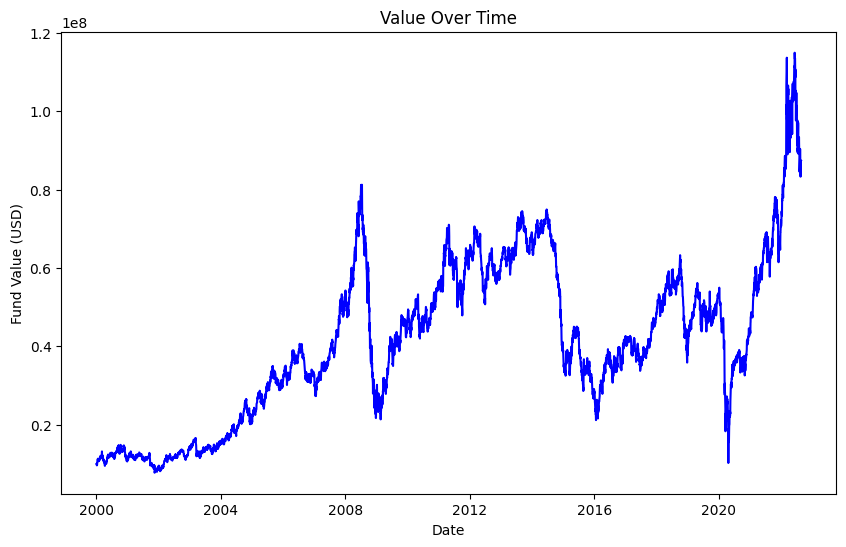

In [25]:
# Define parameters
initial_fund_value = 10_000_000  # $10M initial investment
lot_size = 1000  # 1,000 barrels per contract
transaction_cost_rate = 0.0005  # 0.05% per transaction
margin_requirement_rate = 0.10  # 10% margin requirement
risk_free_rate = 0.04  # 4% annual risk-free rate

# Fund simulation dataset
fund_simulation = oil_with_returns[['Dates', 'second_nearby', 'price', 'Daily_Return']].copy()

# Initialize variables
fund_simulation['contracts_held'] = np.floor(initial_fund_value / (fund_simulation['price'].iloc[0] * lot_size))
fund_simulation['fund_value'] = initial_fund_value
fund_simulation['margin_held'] = fund_simulation['contracts_held'] * fund_simulation['price'] * lot_size * margin_requirement_rate
fund_simulation['collateral'] = initial_fund_value - fund_simulation['margin_held']
fund_simulation['transaction_cost'] = 0
fund_simulation['collateral_interest'] = 0

fund_simulation['fund_value'] = fund_simulation['fund_value'].astype(float)
fund_simulation['collateral_interest'] = fund_simulation['collateral_interest'].astype(float)
fund_simulation['transaction_cost'] = fund_simulation['transaction_cost'].astype(float)

# Simulate the fund performance
for i in range(1, len(fund_simulation)):
    # Rollover logic: Adjust for transaction costs every 5 business days before expiry
    if i % 5 == 0:
        # Calculate transaction cost for rolling contracts
        rollover_cost = fund_simulation.at[i-1, 'contracts_held'] * fund_simulation.at[i-1, 'price'] * lot_size * transaction_cost_rate
        fund_simulation.at[i, 'transaction_cost'] = rollover_cost
        fund_simulation.at[i, 'fund_value'] -= rollover_cost

    # Update fund value based on daily return
    fund_simulation.at[i, 'fund_value'] = fund_simulation.at[i-1, 'fund_value'] * (1 + fund_simulation.at[i, 'Daily_Return'])

    # Calculate margin held and collateral
    fund_simulation.at[i, 'margin_held'] = fund_simulation.at[i, 'contracts_held'] * fund_simulation.at[i, 'price'] * lot_size * margin_requirement_rate
    fund_simulation.at[i, 'collateral'] = fund_simulation.at[i, 'fund_value'] - fund_simulation.at[i, 'margin_held']

    # Ensure collateral is non-negative
    if fund_simulation.at[i, 'collateral'] < 0:
        # Simulate margin call (adjust fund value to cover margin shortfall)
        margin_call = abs(fund_simulation.at[i, 'collateral'])
        fund_simulation.at[i, 'fund_value'] += margin_call
        fund_simulation.at[i, 'collateral'] = 0  # No remaining collateral after margin call

    # Add daily interest on collateral
    fund_simulation.at[i, 'collateral_interest'] = fund_simulation.at[i, 'collateral'] * (risk_free_rate / 252)
    fund_simulation.at[i, 'fund_value'] += fund_simulation.at[i, 'collateral_interest']

plt.figure(figsize=(10, 6))
plt.plot(fund_simulation['Dates'], fund_simulation['fund_value'], color='blue')
plt.title("Value Over Time")
plt.xlabel("Date")
plt.ylabel("Fund Value (USD)")
plt.show()


The fund demonstrates significant growth over the simulation period, reaching a peak of over $100 million by 2021–2022. This growth underscores the profitability of the managed futures strategy.

# Impact of Frequent Rollovers
**Transaction Costs**: Frequent rollovers, occurring every five business days before expiration, introduce regular transaction costs. When accumulated, these costs slightly dampen the fund's compounding returns over time. This effect is reflected in the smoother yet somewhat dampened upward trajectory compared to an idealized model without costs.

**Exposure During Volatility**: Rollovers during periods of heightened market volatility (e.g., 2008 and 2020) amplify the fund’s exposure to price swings. This is evident in the sharp spikes and subsequent drawdowns during these periods.

**Directional Trends**: The fund capitalizes on strong directional trends, such as the 2007–2008 oil price rally and the 2020 recovery. However, it suffers during rapid reversals, including the 2008 crash and the early disruptions of the COVID-19 pandemic.

# Performance During Crisis Periods

**2008 Financial Crisis**:
The significant spike and subsequent drop reflect the sharp increase in oil prices leading up to mid-2008, followed by their collapse during the financial crisis.
Rollovers during this period incurred substantial transaction costs due to heightened volatility. The fund still remains solvent due to effective margin management and collateral stability.

**2020 COVID-19 Pandemic**:
The dramatic rise and fall during 2020–2021 highlight the extreme volatility in the energy markets, including the unprecedented WTI futures price turning negative in April 2020.
While the fund capitalized on the recovery, the jagged pattern in the trajectory highlights the cost of frequent rollovers during this turbulent period.


# Margin Requirements and Stability
**Drawdown Protection**: By maintaining a 10% margin requirement, the fund avoids catastrophic losses during significant drawdowns. Margin calls ensure stability and prevent insolvency during extreme events such as 2008 and 2020.

**Collateral Interest**: During stable periods between crises (e.g., 2010–2019), the fund exhibits steady growth. Interest earned on unused collateral, assumed at 4% annually, helps offset some of the transaction costs, contributing to the fund’s upward momentum.



# Advantages of Rolling to the Third Nearby
Rolling to the third nearby provides flexibility in managing positions and reduces exposure to extreme short-term volatility in the front-month contract. We can avoid continuously rolling in contangoed front-month markets therefore mitigating excessive roll decay.

**Strategy Strengths**

Flexibility
*   Rolling to the third nearby continues to provide greater flexibility in managing positions, as it reduces exposure to the heightened volatility of the front-month contract.

Roll Decay Mitigation in Contango
*   By moving beyond the front-month and rolling into the third nearby, the strategy avoids excessive roll decay in prolonged contango markets (where near-term prices are lower than longer-dated prices). This mitigates the negative impact of consistently buying higher-priced contracts and selling lower-priced contracts.

Crisis Navigation
*   The fund capitalizes on large directional trends (e.g., 2007–2008 and 2020–2021), performing particularly well in volatile and trending markets.


**Strategy Weaknesses**

Costs in Prolonged Contango
*   The strategy still incurs negative roll yield in prolonged contango, even when rolling to the third nearby. In markets like crude oil, prolonged contango periods reduce profitability due to the consistent cost of rolling higher-priced contracts.

Vulnerability to Rapid Reversals
* The strategy remains exposed to rapid price reversals because the contracts being rolled still follow broader market trends. These reversals can result in substantial drawdowns.

In [16]:
def calculate_weekly_returns(data, value_col, return_col):
    """
    Calculates weekly returns for a given column in the dataset.
    """
    weekly_data = data.groupby('week').agg({value_col: 'last'}).reset_index()
    weekly_data[return_col] = weekly_data[value_col].pct_change()
    return weekly_data

def rolling_regression(y, X, window_size):
    """
    Performs rolling regression to calculate rolling alpha and beta.
    """
    model = RollingOLS(y, X, window=window_size)
    rolling_res = model.fit()
    return rolling_res

In [26]:
print(spx_data['Dates'].head(10))


0     1/3/95
1     1/4/95
2     1/5/95
3     1/6/95
4     1/9/95
5    1/10/95
6    1/11/95
7    1/12/95
8    1/13/95
9    1/16/95
Name: Dates, dtype: object


In [27]:
# Add 'week' column for fund_simulation and spx_data
spx_data['Dates'] = pd.to_datetime(spx_data['Dates'], format='%m/%d/%y', errors='coerce')
fund_simulation['week'] = fund_simulation['Dates'].dt.to_period('W').apply(lambda r: r.start_time)
spx_data['week'] = spx_data['Dates'].dt.to_period('W').apply(lambda r: r.start_time)

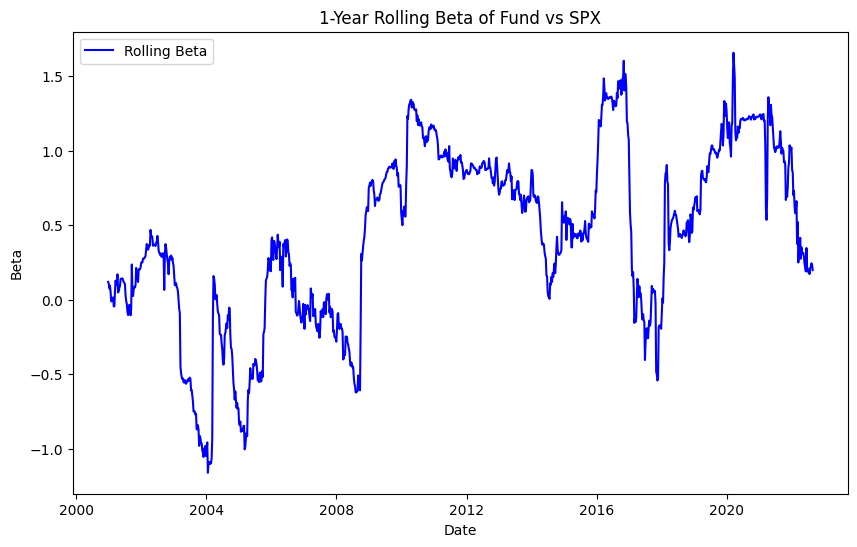

In [19]:
# Calculate weekly returns for fund and SPX
fund_weekly = calculate_weekly_returns(fund_simulation, 'fund_value', 'weekly_return')
spx_weekly = calculate_weekly_returns(spx_data, 'spx_index', 'weekly_spx_return')

# Merge weekly returns on 'week'
merged_weekly = pd.merge(fund_weekly, spx_weekly, on='week', how='inner')

# Prepare data for rolling regression
X = sm.add_constant(merged_weekly['weekly_spx_return'])  # Add constant for intercept
y = merged_weekly['weekly_return']

# Perform rolling regression
rolling_window_size = 52
rolling_res = rolling_regression(y, X, rolling_window_size)

# Add rolling alpha and beta to the merged DataFrame
merged_weekly['rolling_alpha'] = rolling_res.params['const']
merged_weekly['rolling_beta'] = rolling_res.params['weekly_spx_return']

plt.figure(figsize=(10, 6))
plt.plot(merged_weekly['week'], merged_weekly['rolling_beta'], label='Rolling Beta', color='blue')
plt.title("1-Year Rolling Beta of Fund vs SPX")
plt.xlabel("Date")
plt.ylabel("Beta")
plt.legend()
plt.show()


## Rolling Beta Interpretation

 1. **Beta of 1**:
A rolling beta of 1 implies that the fund's returns are perfectly correlated with the S&P 500 (SPX). This means that the fund moves in line with the equity market, reflecting similar directional trends. The fund's performance matches the overall market movements.

2. **Beta Greater Than 1**:
When the beta exceeds 1, it suggests that the fund is more volatile than the SPX. This means that the fund amplifies the moves of the stock market. A higher beta indicates a more aggressive risk profile, particularly during periods when the equity market is rising. In such times, the fund captures more significant price movements.

3. **Negative Beta**:
A negative beta implies that the fund moves inversely to the SPX, meaning the fund tends to perform well when equities are falling. This inverse relationship is typically observed during times of market stress or when commodities behave differently from equities.

---

### **Key Time Periods and Observations:**

#### **2003, 2008, 2020**:
These periods saw negative beta values, signaling that the fund provided a hedge against equity market declines.
In 2008, during the financial crisis, the fund demonstrated strong inverse correlation with the SPX, likely due to the divergence between commodity and equity markets during the economic turmoil. Similarly, during the 2020 COVID-19 pandemic, the beta dropped sharply, reflecting the fund's ability to offset equity losses amidst extreme energy market volatility.

#### **2010–2015 and 2017–2019**:
During these periods, beta stabilized near or above 1, showing that the fund's performance aligned closely with the equity market. This suggests that, in periods of economic stability or growth, the fund's commodities followed broader equity trends, resulting in higher correlations.

---

### **Sharp Fluctuations in Beta:**
The dramatic spikes in beta during certain periods indicate heightened volatility in the fund's relationship with the SPX. These could reflect sudden changes in commodity prices, interest rate shifts, or macroeconomic events that disrupted the usual market dynamics.

The beta visualization highlights the fund's defensive qualities during economic crises, demonstrating its effectiveness as a risk-off strategy. During periods of market turmoil, the strategy’s negative beta indicates its ability to provide diversification and hedge against equity market downturns.

**Amplified Returns in Bull Markets**

In bullish market conditions, the fund's beta exceeding 1 underscores its potential to outperform the S&P 500 (SPX) by capturing outsized returns. However, this elevated beta also implies a higher risk profile during market downturns, exposing the fund to amplified losses during adverse conditions.

**Sensitivity to Market Conditions**

The frequent fluctuations in beta reflect the fund's dynamic responsiveness to changing market environments. These shifts showcase its ability to adapt to movements in commodity prices, macroeconomic trends, and external shocks, making it a versatile strategy across diverse market scenarios.

The fund’s negative beta during downturns demonstrates its role as a hedge against equity losses. This diversification benefit persists because commodities are influenced by fundamentally different drivers than equities, such as supply-demand dynamics and geopolitical factors. Even with the rolling strategy to the third nearby, the fund maintains its defensive characteristics during equity market declines, highlighting its effectiveness across market environments.

# Considerations

**Market Structure Timing**:

The success of this strategy still hinges on understanding the market structure and timing rollovers effectively. Rolling during backwardation enhances profitability by capturing positive roll yield.

**Risk-Reward Balance**:

This strategy remains suitable for investors who can tolerate higher risks in exchange for consistent long-term growth during trending markets.